In [1]:
# Install the transformers package WITH the ESM model. 
# It is unfortunately not available in the official release yet.
#!git clone -b add_esm-proper --single-branch https://github.com/liujas000/transformers.git 
#!pip -q install ./transformers

In [25]:
# Load packages
import time, datetime, warnings, torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from transformers import pipeline, ESMTokenizer, ESMForSequenceClassification, AdamW, logging
from transformers import get_linear_schedule_with_warmup as linear_scheduler
from transformers import get_constant_schedule_with_warmup as constant_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot

# Use CUDA if available:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("- CUDA IS USED -")
else:
    device = torch.device("cpu")

# Stop verbose transformers logging:
logging.set_verbosity_error()

# Stop sklearn warnings
warnings.filterwarnings('ignore')

In [26]:
# Timing helper function
def time_step(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
# What is this notebook about?
generator = pipeline("text-generation", model = "gpt2", pad_token_id = 50256, num_return_sequences=1)
print(generator("This notebook is all about proteins, friends and ")[0]['generated_text'])

This notebook is all about proteins, friends and iced tea. It's not all about drinking too much. It's all about eating something that isn't an ice cream. That's some cool, weird, tasty food.

In the last


In [28]:
# Data preprocessing

# Get sequences, accession number and main category labels:

sequence = ""
sequences = list()
acc_num = list()
main_cat = list()

first = True
with open("../data/terp.faa") as file:
    
    first_acc = file.readline()
    acc_num.append(first_acc.split(">")[1].strip())
    main_cat.append(first_acc.split("_")[1].strip())

    for line in file:
        if line.startswith(">"):
            sequences.append(sequence)
            sequence = ""
            acc_num.append(line.split(">")[1].strip())
            main_cat.append(line.split("_")[1].strip())
        else:
            sequence += line.strip()
    
    # Add last sequence
    sequences.append(sequence)

# Create numbered labels for main categories:

main2label = {c: l for l, c in enumerate(sorted(set(main_cat)))}
label2main = {l: c for c, l in main2label.items()}

# Create class translation dictionary for accession numbers:

acc2class = dict()

with open("../data/class_vs_acc_v2.txt", "r") as file:
    for line in file:
        t_class = line.split("\t")[0]
        acc = line.split("\t")[1].strip()[1:]
        acc2class[acc] = t_class

# Create numbered labels for classes:
        
class2label = {c: l for l, c in enumerate(sorted(set(acc2class.values())))}
label2class = {l: c for c, l in class2label.items()}

print(
    f"The files contain:",
    f"{len(sequences)} sequences in",
    f"{len(set(main_cat))} main categories and",
    f"{len(set(acc2class.values()))} classes")

The files contain: 534 sequences in 10 main categories and 49 classes


In [29]:
# Choose between category and class:
labels = main_cat
#labels = acc_num # This will translate to class later.

# Split into training and validation set. Is this necessary?

train_seq, val_seq, train_labels, val_labels = train_test_split(sequences, labels, test_size=.1)

print(f"Training size: {len(train_seq)} Validation size: {len(val_seq)}")

Training size: 480 Validation size: 54


In [30]:
# Tokenizer:
tokenizer = ESMTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D",
                                         do_lower_case=False)

In [31]:
class SequenceDataset(Dataset):
    def __init__(self, input_sequences, input_labels, categories=True):
        
        # Init is run once, when instantiating the dataset class.
        #
        # Either supply with:
        #  Main categories - category classification
        #  Accession numbers - class classifcation 
        
        # The xx2label turns the label from text to a number from 0-(N-1) 
        if categories:
            self.labels = [main2label[cat] for cat in input_labels]
        else:
            self.labels = [class2label[acc2class[acc]] for acc in input_labels]
        
        # Tokenize sequence and pad to longest sequence in dataset.
        # Return pytorch-type tensors
        self.sequences = tokenizer(
                                input_sequences,
                                padding = 'longest',
                                return_tensors = 'pt')
        # Save label type
        self.label_type_cat = categories
        
    def classes(self):
        
        # Returns the classes in the dataset (optional function)
        return self.labels

    def __len__(self):
        
        # Returns the number of samples in dataset (required)
        return len(self.labels)

    def __getitem__(self, idx):
        
        # Returns a sample at position idx (required)
        # The sample includes:
        # - Input id's for the sequence
        # - Attention mask (to only focus on the sequence and not padding)
        # - Label (one-hot encoded)
        
        input_ids = self.sequences['input_ids'][idx]
        attention_mask = self.sequences['attention_mask'][idx]
        label = torch.tensor(self.labels[idx])
        num_labels = len(main2label.values()) if self.label_type_cat else len(class2label.values())
        
        sample = dict()
        sample['input_ids'] = input_ids
        sample['attention_mask'] = attention_mask
        sample['label'] = one_hot(label,
                                  num_classes = num_labels).to(torch.float)
        return sample

In [32]:
# Transform data to dataset class:
train_dataset = SequenceDataset(train_seq, train_labels)
val_dataset = SequenceDataset(val_seq, val_labels)


In [55]:
# SETTINGS:

# Model specifications:
num_labels = len(set(train_dataset.classes()))
model_name = "esm2_t6_8M_UR50D"
model_version = "facebook/" + model_name
model = ESMForSequenceClassification.from_pretrained(
    model_version,
    num_labels = num_labels,
    problem_type = "multi_label_classification")

# Data loading:
# The DataLoader splits the dataset by batch size,
# and returns an iter to go through each batch of samples.

epochs = 5
batch_size = 1

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

# Optimizer, learning rate and optional learning rate decay.

learning_rate = 5e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate)
scheduler = linear_scheduler(optimizer,
                             num_warmup_steps = 0,
                             num_training_steps = len(train_loader) * epochs)

# If you don't want decay - uncomment this:
# scheduler = constant_scheduler(optimizer,
#                                num_warmup_steps = 0)

# Logging:
out_name = "_".join([model_name,
                     "E" + str(epochs),
                     "B" + str(batch_size),
                     "T" + datetime.datetime.now().strftime("%m%d%H%M")])

results_file = open("../results/exploration/" + out_name + ".res", "w")
print(f"fold\ttrain_loss\tval_loss\ttrain_accu\tval_accu\tbalanced_train_accu\tbalanced_val_accu",
      file = results_file)

In [56]:
# Training
device = torch.device("cpu")
model.to(device)
total_t0 = time.time()

train_acc = list()
val_acc = list()
train_loss = list()
val_loss = list()

for epoch in range(epochs):
    
    print(f"#------ EPOCH {epoch+1} of {epochs}")
    print(f"#--- Training")
    # Training step

    model.train()
    total_train_loss = 0
    total_train_accuracy = 0
    total_balanced_train_accuracy = 0

    for step, batch in enumerate(train_loader):
        
        if step % 5 == 0:
            time_elapsed = time_step(time.time() - total_t0)
            print(f"#- Batch {step+1} of {len(train_loader)} \t- {time_elapsed} (time elapsed)")
        
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        input_labels = batch['label'].to(device)

        output = model(input_ids,
                       token_type_ids=None,
                       attention_mask=attention_mask,
                       labels=input_labels)

        # Get loss
        total_train_loss += output.loss

        # Get accuracy
        logits = output.logits.detach().cpu().numpy()
        input_labels = input_labels.to('cpu').numpy()
        total_train_accuracy += accuracy_score(input_labels.argmax(axis=1),
                                               logits.argmax(axis=1))

        total_balanced_train_accuracy += balanced_accuracy_score(
            input_labels.argmax(axis=1),
            logits.argmax(axis=1))
        break
        output.loss.backward()
        optimizer.step()
        scheduler.step() # Update learning rate

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    avg_balanced_train_accuracy = total_balanced_train_accuracy / len(train_loader)
    train_loss.append(float(avg_train_loss))
    train_acc.append(float(avg_train_accuracy))

    print(f"Average training loss: {avg_train_loss:.2f}")
    print(f"Average training accuracy: {avg_train_accuracy:.2f}")
    print(f"Average balanced training accuracy: {avg_balanced_train_accuracy:.2f}")

    # Evaluation step
    print(f"\n#****** Validation")
    
    model.eval()
    t0 = time.time()
    total_val_loss = 0
    total_val_accuracy = 0
    total_balanced_val_accuracy = 0

    for batch in val_loader:

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Dont construct unnecessary compute-graph:
        with torch.no_grad():
            output = model(input_ids,
                           token_type_ids=None,
                           attention_mask=attention_mask,
                           labels=labels)
        
        total_val_loss += output.loss
        
        logits = output.logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        

        
        total_val_accuracy += accuracy_score(labels.argmax(axis=1),
                                             logits.argmax(axis=1))
        
        total_balanced_val_accuracy += balanced_accuracy_score(
                                        labels.argmax(axis=1),
                                        logits.argmax(axis=1))
        break
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    avg_balanced_val_accuracy = total_balanced_val_accuracy / len(val_loader)
    validation_time = time_step(time.time() - t0)
    val_loss.append(float(avg_val_loss))
    val_acc.append(float(avg_val_accuracy))

    print(f"Average validation loss: {avg_val_loss:.2f}")
    print(f"Average validation accuracy: {avg_val_accuracy:.2f}")
    print(f"Average balanced validation accuracy: {avg_balanced_val_accuracy:.2f}")
    print(f"Validation time: {validation_time}\n")

    # Save output:
    print(epoch + 1,
          f"{avg_train_loss:.4f}",
          f"{avg_val_loss:.4f}",
          f"{avg_train_accuracy:.4f}",
          f"{avg_val_accuracy:.4f},"
          f"{avg_balanced_train_accuracy:.4f}",
          f"{avg_balanced_val_accuracy:.4f}",
          sep = "\t",
          file = results_file)

print("Success!\n")
print(f"Total training time: {time_step(time.time() - total_t0)}")
results_file.close()

#------ EPOCH 1 of 5
#--- Training
#- Batch 1 of 480 	- 0:00:00 (time elapsed)
Average training loss: 0.00
Average training accuracy: 0.00
Average balanced training accuracy: 0.00

#****** Validation
Average validation loss: 0.01
Average validation accuracy: 0.00
Average balanced validation accuracy: 0.00
Validation time: 0:00:00

#------ EPOCH 2 of 5
#--- Training
#- Batch 1 of 480 	- 0:00:01 (time elapsed)
Average training loss: 0.00
Average training accuracy: 0.00
Average balanced training accuracy: 0.00

#****** Validation
Average validation loss: 0.01
Average validation accuracy: 0.02
Average balanced validation accuracy: 0.02
Validation time: 0:00:00

#------ EPOCH 3 of 5
#--- Training
#- Batch 1 of 480 	- 0:00:02 (time elapsed)
Average training loss: 0.00
Average training accuracy: 0.00
Average balanced training accuracy: 0.00

#****** Validation
Average validation loss: 0.01
Average validation accuracy: 0.02
Average balanced validation accuracy: 0.02
Validation time: 0:00:01

#

<Figure size 640x480 with 0 Axes>

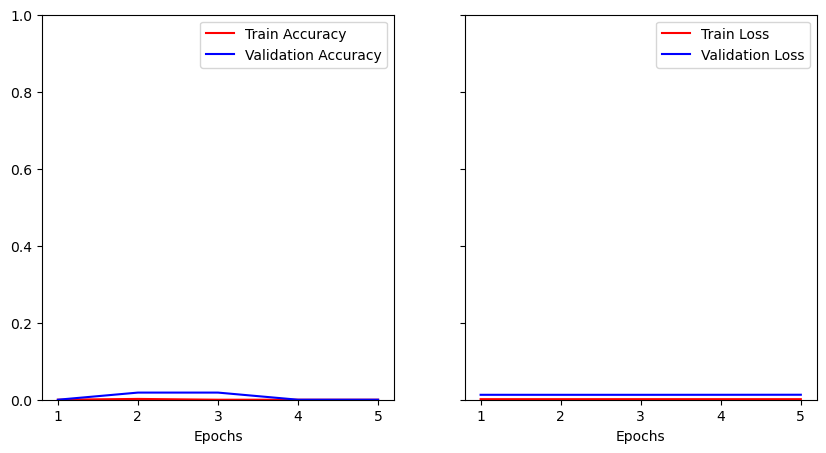

In [62]:
# Save output as a plot

epoch = np.arange(1, epochs + 1)
plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax[0].plot(epoch, train_acc, 'r', epoch, val_acc, 'b')
ax[0].legend(['Train Accuracy','Validation Accuracy'])
ax[0].set_xlabel('Epochs')
ax[1].plot(epoch, train_loss, 'r', epoch, val_loss, 'b')
ax[1].legend(['Train Loss','Validation Loss'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylim(0,1)
plt.savefig("../results/exploration/" + out_name + ".pdf")